In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder

In [13]:
# Load your dataset
df = pd.read_csv('./../data/airline-passengers.csv', parse_dates=['Month'], index_col='Month')
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
# Extract month as a feature
df['Month_Feature'] = df.index.month

# One-hot encode the month feature
encoder = OneHotEncoder(sparse_output=False, drop="first")
month_encoded = encoder.fit_transform(df[['Month_Feature']])
month_encoded_df = pd.DataFrame(month_encoded, index=df.index, columns=[f'month_{i+1}' for i in range(month_encoded.shape[1])])

# Join the encoded features with the original dataframe
df = pd.concat([df, month_encoded_df], axis=1)
df[f'lag_{12}'] = df['Passengers'].shift(12)
df = df.dropna()
print(df.columns)
df.head()

Index(['Passengers', 'Month_Feature', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'lag_12'],
      dtype='object')


,Passengers,Month_Feature,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,lag_12
Month,,,,,,,,,,,,,,
1950-01-01,115,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112.0
1950-02-01,126,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0
1950-03-01,141,3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0
1950-04-01,135,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0
1950-05-01,125,5,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0


In [15]:
month_encoded_df.head()

,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11
Month,,,,,,,,,,,
1949-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-04-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1949-05-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
# Define training and testing datasets (last 12 months as test set)
train = df[:-12]
test = df[-12:]

# Prepare datasets for LightGBM
features = [f'month_{i+1}' for i in range(11)] + ["lag_12"]
X_train, y_train = train[features], train['Passengers']
X_test, y_test = test[features], test['Passengers']

X_train.head()


,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,lag_12
Month,,,,,,,,,,,,
1950-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,112.0
1950-02-01,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,118.0
1950-03-01,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,132.0
1950-04-01,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,129.0
1950-05-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,121.0


In [17]:
# Configure and train the LightGBM model
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5
}
train_data = lgb.Dataset(X_train, label=y_train)
gbm = lgb.train(params, train_data, num_boost_round=200)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 12
[LightGBM] [Info] Start training from score 276.075000


#### Without Linear_tree option

RMSE: 50.277180093939


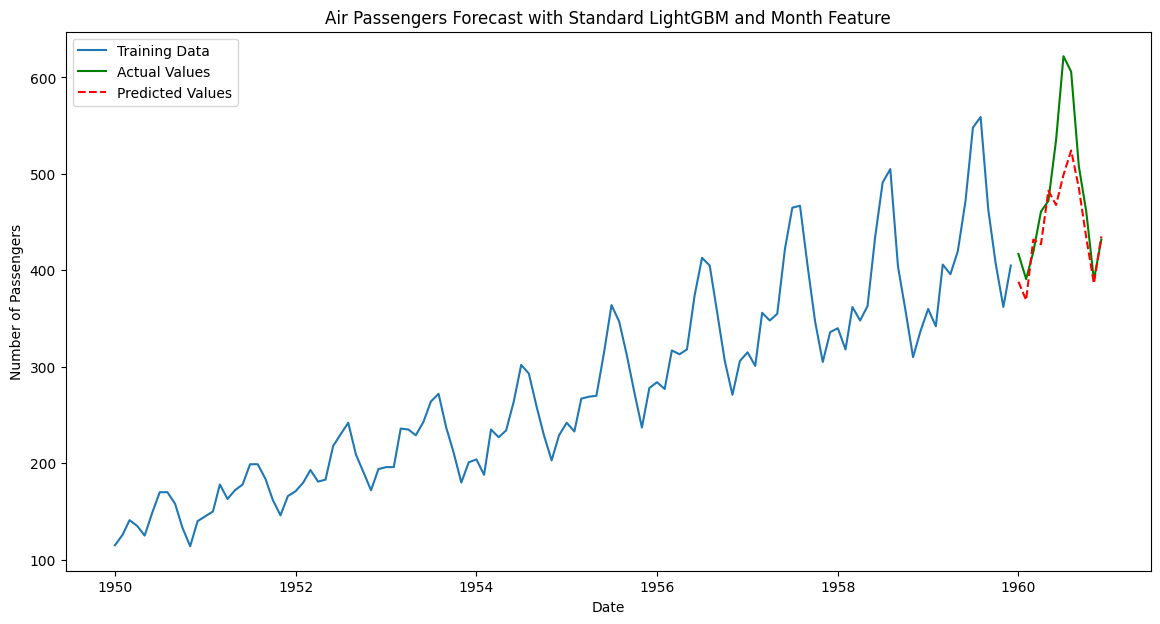

In [18]:
# Forecast the next 12 months
y_pred = gbm.predict(X_test)

# Calculate RMSE for the predictions
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f'RMSE: {rmse}')

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Training Data')
plt.plot(test.index, y_test, label='Actual Values', color='green')
plt.plot(test.index, y_pred, label='Predicted Values', linestyle='--', color='red')
plt.title('Air Passengers Forecast with Standard LightGBM and Month Feature')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()

#### Activating Linear_tree()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 61
[LightGBM] [Info] Number of data points in the train set: 120, number of used features: 12
[LightGBM] [Info] Start training from score 276.075000
RMSE (Linear Tree): 22.090790536002697


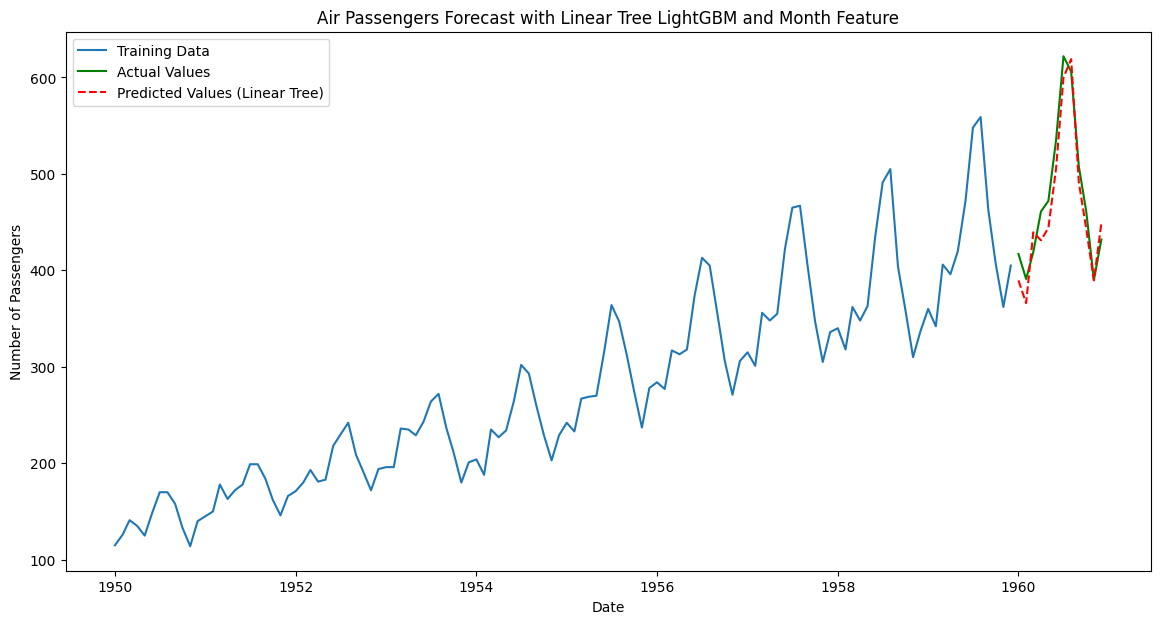

In [19]:
# Configure and train the LightGBM model with linear_tree
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'linear_tree': True,  # Enable linear tree
    'num_leaves': 10,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'min_data_in_leaf': 5
}
train_data = lgb.Dataset(X_train, label=y_train)
gbm_linear = lgb.train(params, train_data, num_boost_round=200)

# Forecast the next 12 months using the linear tree model
y_pred_linear = gbm_linear.predict(X_test)

# Calculate RMSE for the predictions
rmse_linear = np.sqrt(mean_squared_error(y_test, y_pred_linear))
print(f'RMSE (Linear Tree): {rmse_linear}')

# Plotting the actual vs predicted values for linear tree model
plt.figure(figsize=(14, 7))
plt.plot(train.index, y_train, label='Training Data')
plt.plot(test.index, y_test, label='Actual Values', color='green')
plt.plot(test.index, y_pred_linear, label='Predicted Values (Linear Tree)', linestyle='--', color='red')
plt.title('Air Passengers Forecast with Linear Tree LightGBM and Month Feature')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()